### Libraries

In [260]:
#Data Manipulation
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

#Utilities
import time
import warnings
#Models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from skforecast.ForecasterAutoreg import ForecasterAutoreg

#Functionalities
from skforecast.model_selection import backtesting_forecaster
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
parameters = {
    "dataset":{
        "path": "../data/Processed_Data/Demand_Dataset.csv",
        "trainingSize": .70,
        "validationSize": .15,
        "testSize": .15
    },
    "backtesting":{
        "steps": 96,
        "fixedTrainSize": False,
        "refit": False,
    },
    "validation": {
        "n_splits" : 10
    }
}

c:\Users\ssanchez\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



## AutoRegressive Models

### Split Dataset

In [261]:
#Read Dataset {Path Dataset}
df = pd.read_csv(parameters["dataset"]["path"])
df["Date"] = pd.to_datetime(df["Date"])
df.head(5)

Date  Demand  Temperature  Relative_Humidity  \
0 2018-01-01 00:15:00       8    12.967492               60.5   
1 2018-01-01 00:30:00       8    12.972492               61.0   
2 2018-01-01 00:45:00       8    12.977492               61.5   
3 2018-01-01 01:00:00       8    12.982492               62.0   
4 2018-01-01 01:15:00       8    12.709992               61.5   

   Precipitation_Total  Sunshine_Duration  Shortwave_Radiation  \
0                  0.0                0.0                  0.0   
1                  0.0                0.0                  0.0   
2                  0.0                0.0                  0.0   
3                  0.0                0.0                  0.0   
4                  0.0                0.0                  0.0   

   Direct_Shortwave_Radiation  Diffuse_Shortwave_Radiation  Year  ...  \
0                         0.0                          0.0  2018  ...   
1                         0.0                          0.0  2018  ...   
2                         0.0                          0.0  2018  ...   
3                         0.0                          0.0  2018  ...   
4                         0.0                          0.0  2018  ...   

   DayOfWeek  DayOfYear  Minute  Demand_7d  isWeekend  Hour_sen  Hour_cos  \
0          0          1      15        0.0      False  0.000000  1.000000   
1          0          1      30        0.0      False  0.000000  1.000000   
2          0          1      45        0.0      False  0.000000  1.000000   
3          0          1       0        0.0      False  0.258819  0.965926   
4          0          1      15        0.0      False  0.258819  0.965926   

   Demand_24h  isHoliday  Season  
0           0       True       0  
1           0       True       0  
2           0       True       0  
3           0       True       0  
4           0       True       0  

[5 rows x 22 columns]

In [262]:
#Setting Dataset Separators
trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
validationSize = trainingSize + int(parameters["dataset"]["validationSize"] * df.shape[0])
trainingLastDate = str(df.loc[[trainingSize]]["Date"].values[0])
validationLastDate = str(df.loc[[validationSize]]["Date"].values[0])

#Set Date as Index an Data Frequency to 15 mins
df = df.set_index("Date")
df = df.asfreq("15min")

#Split Dataset
x_train = df.loc[:trainingLastDate, :].copy()
x_val = df.loc[trainingLastDate:validationLastDate, :].copy()
x_test = df.loc[validationLastDate:, :].copy()

#THe first row is repeated
x_val = x_val.iloc[1:]
x_test = x_test.iloc[1:]

#Prints
print(f"Whole Dataset Size: {df.shape[0]}")
print(f"Trainig Dataset Size: {x_train.shape[0]} From: {x_train.index.min()} to {x_train.index.max()}")
print(f"Validation Dataset Size: {x_val.shape[0]} From: {x_val.index.min()} to {x_val.index.max()}")
print(f"Test Dataset Size: {x_test.shape[0]} From: {x_test.index.min()} to {x_test.index.max()}")

Whole Dataset Size: 70080
Trainig Dataset Size: 49057 From: 2018-01-01 00:15:00 to 2019-05-27 00:15:00
Validation Dataset Size: 10512 From: 2019-05-27 00:30:00 to 2019-09-13 12:15:00
Test Dataset Size: 10511 From: 2019-09-13 12:30:00 to 2020-01-01 00:00:00


In [263]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_train.index, y=x_train["Demand"], mode="lines", name="Train"))
fig.add_trace(go.Scatter(x=x_val.index, y=x_val["Demand"], mode="lines", name="Validation"))
fig.add_trace(go.Scatter(x=x_test.index, y=x_test["Demand"], mode="lines", name="Test"))
fig.update_layout(
    title = "Dataset Partition",
    xaxis_title = "Date",
    yaxis_title ="Demand (MWh)",
    width = 1000,
    height = 400,
    margin = dict(l=30, r=20, t=35, b=60),
    legend = dict(
        orientation = "h",
        yanchor = "bottom",
        y = 1.05,
        xanchor = "right",
        x=1
    )
)
fig.show()

In [264]:
def plotPredictions(dates, y_pred, y_test):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Demand",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    fig.show()

### Backtesting

In [265]:
def run_backtesting(model, data, initial_train_size, exog,params):
    init = time.time()
    forecaster = ForecasterAutoreg(
        regressor = model,
        transformer_y = StandardScaler(),
        lags=1
    )
    metrics, predictions = backtesting_forecaster(
        forecaster = forecaster,
        steps = len(data) - initial_train_size,
        y = data["Demand"],
        metric = ['mean_absolute_error', 'mean_squared_error'],
        exog = exog,
        initial_train_size = initial_train_size,
        refit = params["backtesting"]["refit"],
        fixed_train_size = parameters["backtesting"]["fixedTrainSize"],
        verbose = False,
        show_progress = True,
        n_jobs='auto'
    )
    end = time.time()
    return predictions, metrics, (end-init)

In [266]:
models = {
    'LGBM': LGBMRegressor(n_estimators=100, random_state=123, verbose=-1),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=123),
    'KNNR': KNeighborsRegressor(n_neighbors=20, weights='distance'),
    #"SVR": SVR(kernel='rbf'),
    #'GBM': GradientBoostingRegressor(n_estimators=100, random_state=123),
    #'RF': RandomForestRegressor(n_estimators=100, random_state=123),
    #'ADA': AdaBoostRegressor(n_estimators=100, random_state=123)
}
results = {}
x_train_val = pd.concat([x_train, x_val], axis=0)
x_train_val = x_train_val.asfreq('15min')
x_train_val_exog = x_train_val.drop("Demand", axis=1)
for model_name, model in models.items():
    predictions, metrics, model_time = run_backtesting(model, x_train_val, len(x_train), x_train_val_exog, parameters)
    results[model_name] = {
        'predictions': predictions,
        'MAE': metrics[0],
        'RMSE': np.sqrt(metrics[1]),
        'Time': model_time
    }
    print(f"Model {model_name}: MAE: {metrics[0]}, RMSE: {np.sqrt(metrics[1])}, Time: {model_time:.6f} seconds")

    

100%|██████████| 1/1 [00:06<00:00,  6.29s/it]


Model LGBM: MAE: 25.58739497223745, RMSE: 47.588530766597664, Time: 6.869649 seconds


100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


Model XGBoost: MAE: 26.568915299279787, RMSE: 47.527361504598964, Time: 3.176180 seconds


100%|██████████| 1/1 [00:20<00:00, 20.26s/it]

Model KNNR: MAE: 23.347011192029395, RMSE: 36.87896487354406, Time: 20.300855 seconds


### Hyperparameter Tuning

In [267]:
from skforecast.model_selection import grid_search_forecaster

#Lags used as Predictors
lags_grid = [1, 96, 96*2, 96*7, [1, 2, 3], [1, 96], [1, 96, 96*7], [1, 2, 3, 4, 5, 96, 96*7]]

#Regressor Hyperparameters
param_grid = {
    'n_neighbors': [10, 20, 30, 40, 50],
    'weights': ['uniform', 'distance']
    }

forecaster = ForecasterAutoreg(
    regressor = KNeighborsRegressor(n_neighbors=5, weights= 'distance'),
    transformer_y = StandardScaler(),
    lags=24*7
)

'''
results = grid_search_forecaster(
    forecaster = forecaster,
    y = x_train_val["Demand"],
    param_grid = param_grid,
    steps = len(x_train_val) - len(x_train),
    lags_grid = lags_grid,
    exog = x_train_val_exog,
    refit = parameters["backtesting"]["refit"],
    metric = ["mean_squared_error", 'mean_absolute_error'],
    initial_train_size = len(x_train),
    n_jobs = 'auto',
    verbose = False,
    show_progress=True,
    return_best = True,
    fixed_train_size=parameters['backtesting']["fixedTrainSize"]
)
results.head(10)
'''

'\nresults = grid_search_forecaster(\n    forecaster = forecaster,\n    y = x_train_val["Demand"],\n    param_grid = param_grid,\n    steps = len(x_train_val) - len(x_train),\n    lags_grid = lags_grid,\n    exog = x_train_val_exog,\n    refit = parameters["backtesting"]["refit"],\n    metric = ["mean_squared_error", \'mean_absolute_error\'],\n    initial_train_size = len(x_train),\n    n_jobs = \'auto\',\n    verbose = False,\n    show_progress=True,\n    return_best = True,\n    fixed_train_size=parameters[\'backtesting\']["fixedTrainSize"]\n)\nresults.head(10)\n'

In [268]:
forecaster = ForecasterAutoreg(
    regressor = KNeighborsRegressor(n_neighbors=25, weights= 'uniform'),
    transformer_y = StandardScaler(),
    lags=24*7
)
forecaster.fit(y=x_train_val["Demand"], exog=x_train_val_exog)
x_test_exog = x_test.drop("Demand", axis=1)
predictions = forecaster.predict(steps=len(x_test_exog), exog=x_test_exog)

In [269]:
print(f"TEST MAE: {mean_absolute_error(x_test["Demand"].values, predictions.values)}, RMSE: {root_mean_squared_error(x_test["Demand"].values, predictions.values)}")
plotPredictions(predictions.index, np.asarray(predictions.values), np.asarray(x_test["Demand"].values))

TEST MAE: 23.89312529730758, RMSE: 36.530129312113026


In [270]:
#Best Forecaster
forecaster

ForecasterAutoreg 
Regressor: KNeighborsRegressor(n_neighbors=25) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 168 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exoge

## Conventional Regression Models

### Split Dataset

In [271]:
df2 = pd.read_csv(parameters["dataset"]["path"], index_col=None)
dates = df2["Date"]
df2 = df2.drop(columns=["Date"])

trainingSize = int((parameters["dataset"]["trainingSize"] + parameters["dataset"]["validationSize"])* df2.shape[0])

X_train = df2.loc[:trainingSize, :].copy()
X_train_dates = dates.loc[:trainingSize].copy()
X_test = df2.loc[trainingSize:, :].copy()
X_test_dates = dates.loc[trainingSize:].copy()

print(f"Training and Validation Size: {trainingSize}")
print(f"Test Size: {len(df2)-trainingSize}")


Training and Validation Size: 59568
Test Size: 10512


### K-Fold Cross Validation

In [272]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tqdm import tqdm

def KFoldCrossValidation(X, y, models, model_names, params):
    results = []
    k = params["validation"]["n_splits"]
    for model, name in tqdm(zip(models, model_names), total=len(models), desc="Models Validation"):
        model_list, mae_list , rmse_list = [name], [], []
        fold_size = len(X) // k
        fold_indices = []
        for i in range(k):
            start_idx = i * fold_size
            end_idx = start_idx + fold_size if i < k - 1 else len(X)

            fold_indices.append((np.arange(start_idx, end_idx), np.concatenate((np.arange(0, start_idx), np.arange(end_idx, len(X))))))

        for fold_idx, (train_idx, test_idx) in enumerate(fold_indices):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae_list.append(mean_absolute_error(y_test, y_pred))
            rmse_list.append(root_mean_squared_error(y_test, y_pred))

        model_list.extend(mae_list)
        model_list.extend(rmse_list)
        model_list.extend([np.mean(mae_list), np.mean(rmse_list)])
        results.append(model_list)
    columns = ["model", "k0_mae", "k1_mae", "k2_mae", "k3_mae", "k4_mae", "k5_mae", "k6_mae", "k7_mae", "k8_mae", "k9_mae",
        "k0_rmse", "k1_rmse", "k2_rmse", "k3_rmse", "k4_rmse", "k5_rmse", "k6_rmse", "k7_rmse", "k8_rmse", "k9_rmse", "mae_mean", "rmse_mean"]
    df = pd.DataFrame(results, columns=columns)
    
    return df

In [273]:
#Standard Scale Numerical Variables
columns = list(X_train.columns)
columns.remove('Demand')
col_preprocessing = ColumnTransformer([
    ('numeric_col_preprocessing', StandardScaler(), columns)
])
pip = Pipeline([('col_preprocessing', col_preprocessing)])

models, models_names = [], []

#Tree Models
for n in [20, 50, 80, 100, 120]:
    LGBM = LGBMRegressor(n_estimators=n, random_state=123, verbose=-1)
    XGB = XGBRegressor(n_estimators=n, random_state=123)
    GBM = GradientBoostingRegressor(n_estimators=n, random_state=123)
    models.append(LGBM)
    models_names.append("LGBM_" + str(n))
    models.append(XGB)
    models_names.append("XGB_" + str(n))
    models.append(GBM)
    models_names.append("GBM_" + str(n))

#KNNr
for n in [10, 20, 30, 40, 50]:
    for weight in ["distance", "uniform"]:
        KNNR = KNeighborsRegressor(n_neighbors=n, weights=weight)
        models.append(KNNR)
        models_names.append("KNNr_" + str(n) + "_" + weight)

#Other Models
models.append(SVR(kernel='rbf'))
models_names.append("SVR")


#Cross Validation
results = KFoldCrossValidation(
    pip.fit_transform(X_train), X_train["Demand"], models, models_names, parameters
)

Models Validation: 100%|██████████| 26/26 [09:48<00:00, 22.64s/it] 


In [274]:
results.sort_values('rmse_mean')

model     k0_mae     k1_mae     k2_mae     k3_mae     k4_mae  \
24   KNNr_50_uniform  25.386983  25.590047  26.417876  25.096383  26.643813   
23  KNNr_50_distance  25.416375  25.563155  26.394092  25.092597  26.632868   
22   KNNr_40_uniform  25.706638  25.638606  26.402682  25.120579  26.690323   
21  KNNr_40_distance  25.748323  25.614010  26.382754  25.125955  26.682175   
20   KNNr_30_uniform  26.192801  25.725360  26.438821  25.200667  26.741671   
19  KNNr_30_distance  26.243813  25.702149  26.420915  25.219036  26.740240   
18   KNNr_20_uniform  26.899002  25.869838  26.506511  25.421424  26.912447   
17  KNNr_20_distance  26.953792  25.854204  26.496602  25.453832  26.917405   
25               SVR  27.001901  25.920530  27.726417  29.746824  28.191214   
2             GBM_20  31.881670  32.408955  27.327346  27.367888  30.289715   
16   KNNr_10_uniform  28.280947  26.337597  26.764218  26.116822  27.443187   
15  KNNr_10_distance  28.323198  26.337067  26.764316  26.160262  27.451406   
5             GBM_50  31.022049  36.278683  26.768956  25.863947  30.086427   
8             GBM_80  31.757400  37.572588  27.077980  25.802937  30.803853   
11           GBM_100  31.883058  38.750533  27.467275  25.910179  31.230704   
14           GBM_120  31.996853  39.196226  27.499935  26.018286  31.578572   
1             XGB_20  33.152001  35.653497  28.172793  25.400048  30.519104   
4             XGB_50  33.773420  36.121480  28.823446  26.314543  31.093922   
7             XGB_80  34.291140  36.803080  28.838408  26.276750  31.156935   
10           XGB_100  34.239258  36.929477  28.957790  26.291407  31.191932   
13           XGB_120  34.588097  37.076709  29.031245  26.414734  31.231097   
0            LGBM_20  35.366891  33.739675  28.563487  25.933209  32.166191   
3            LGBM_50  37.544870  35.856592  28.606354  25.255377  31.999881   
9           LGBM_100  37.142822  36.294995  28.640225  25.410027  32.041574   
6            LGBM_80  37.223955  36.338005  28.575082  25.389922  32.047723   
12          LGBM_120  37.061694  36.272986  28.681700  25.458022  32.066150   

       k5_mae     k6_mae     k7_mae     k8_mae  ...    k2_rmse    k3_rmse  \
24  27.156782  25.469320  26.070584  26.705718  ...  41.750385  41.123737   
23  27.072840  25.467588  26.069458  26.679054  ...  41.752177  41.126065   
22  27.059694  25.495068  26.241326  26.639280  ...  41.836218  41.226656   
21  26.997145  25.501940  26.239814  26.619007  ...  41.840786  41.240158   
20  26.981110  25.595787  26.469428  26.571662  ...  42.010619  41.454540   
19  26.946440  25.614962  26.472917  26.560501  ...  42.017077  41.482598   
18  27.025296  25.863391  26.842464  26.531740  ...  42.323107  41.966669   
17  27.011910  25.899490  26.858091  26.526840  ...  42.333950  42.014422   
25  25.418032  29.230046  26.871074  28.640066  ...  43.021589  45.378849   
2   31.297273  34.167606  28.430185  30.505735  ...  41.272918  39.946048   
16  27.303855  26.901117  27.851051  26.535691  ...  43.128814  43.402567   
15  27.299020  26.942963  27.868158  26.537996  ...  43.139348  43.471536   
5   32.292597  39.511262  28.246980  29.824273  ...  41.351543  40.097571   
8   33.057460  42.303254  28.875552  30.091923  ...  41.664690  40.177125   
11  33.637836  43.119188  28.936968  30.174995  ...  42.067039  39.842570   
14  33.733003  43.243849  29.029828  30.471153  ...  42.122049  39.984715   
1   35.130774  37.945961  28.168124  29.575007  ...  45.956134  40.769319   
4   36.874152  38.244308  28.389396  29.649001  ...  46.879758  40.851842   
7   37.619386  38.196386  28.554025  29.756218  ...  46.638612  40.946229   
10  37.980915  38.301115  28.578051  29.767301  ...  46.742601  40.970596   
13  38.136911  38.311207  28.618029  29.777436  ...  46.751729  41.057975   
0   35.374140  38.566884  31.935326  31.207463  ...  45.712859  40.537410   
3   36.038710  39.937702  31.291299  30.155586  ...  47.177838  41.164016   
9   36.413673  40.490401  31.4339

### Find Best K

In [275]:
def findBestK(X, y, max_k, params):
    final_mae_list, final_rmse_list = [], []
    best_mae, best_rmse, best_k = float('inf'), float('inf'), 0
    
    for k in tqdm(range(1, max_k), total=max_k, desc="Finding Best K..."):
        knn = KNeighborsRegressor(n_neighbors=k, weights='uniform')

        n_splits = params["validation"]["n_splits"]
        mae_list , rmse_list = [], []
        fold_size = len(X) // n_splits
        fold_indices = []
        for i in range(n_splits):
            start_idx = i * fold_size
            end_idx = start_idx + fold_size if i < n_splits - 1 else len(X)

            fold_indices.append((np.arange(start_idx, end_idx), np.concatenate((np.arange(0, start_idx), np.arange(end_idx, len(X))))))

        for fold_idx, (train_idx, test_idx) in enumerate(fold_indices):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            mae_list.append(mean_absolute_error(y_test, y_pred))
            rmse_list.append(root_mean_squared_error(y_test, y_pred))

        mae, rmse = np.mean(mae_list), np.mean(rmse_list)
        final_mae_list.append(mae)
        final_rmse_list.append(rmse)
        if mae <= best_mae and rmse <= best_rmse:
            best_mae = mae
            best_rmse = rmse
            best_k = k

    #MAE and RMSE plots per k
    fig = make_subplots(rows=2, cols=1, subplot_titles=("MAE Value per K", "RMSE Value per K"))
    fig.append_trace(go.Scatter(x=list(range(1, max_k)), y=final_mae_list, mode='lines'), row=1, col=1)
    fig.append_trace(go.Scatter(x=list(range(1, max_k)), y=final_rmse_list, mode='lines'), row=2, col=1)
    fig.update_xaxes(title_text="K Value", row=1, col=1)
    fig.update_yaxes(title_text="Mean Absolute Error", row=1, col=1)
    fig.update_xaxes(title_text="K Value", row=2, col=1)
    fig.update_yaxes(title_text="Root Mean Squared Error", row=2, col=1)
    fig.update_layout(
        width = 850,
        height = 700,
        margin=dict(l=20, r=20, t=35, b=25),
        showlegend=False
    )
    fig.show()
    print(f"Best K: {best_k}, MAE: {best_mae}, RMSE: {best_rmse}")
    
findBestK(pip.fit_transform(X_train), X_train["Demand"], 100, parameters)

Finding Best K...:  34%|███▍      | 34/100 [05:33<10:47,  9.81s/it]


KeyboardInterrupt: 

### Test

In [ ]:
# Testing
model = KNeighborsRegressor(n_neighbors=33, weights='uniform')

def test(X_train, X_test, model, type="All"):
    X_train, y_train = pip.fit_transform(X_train), X_train["Demand"]
    if type == "All":
        X_test, y_test = pip.fit_transform(X_test), X_test["Demand"]
    elif type == 'Day':
        X_test, y_test = pip.fit_transform(X_test.iloc[:96]), X_test.iloc[:96]["Demand"]
    elif type == 'Week':
        X_test, y_test = pip.fit_transform(X_test.iloc[:96*7]), X_test.iloc[:96*7]["Demand"]
    else:
        return f"Option {type} not available"
    #Train Model
    model.fit(X_train, y_train)

    #Predict
    y_pred = model.predict(X_test)

    #Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    print(f"Nº of Days Predicted: {len(y_test) // 96} == {len(y_test)} lags, Test MAE: {mae}, RMSE: {rmse}")
    plotPredictions(X_test_dates, y_pred, y_test)
test(X_train, X_test, model, 'All')

Nº of Days Predicted: 109 == 10512 lags, Test MAE: 18.230426410220932, RMSE: 33.117008580834174


### Tune Exogenous Variables

Text(0.5, 1.0, 'Pearson Correlation Matrix')

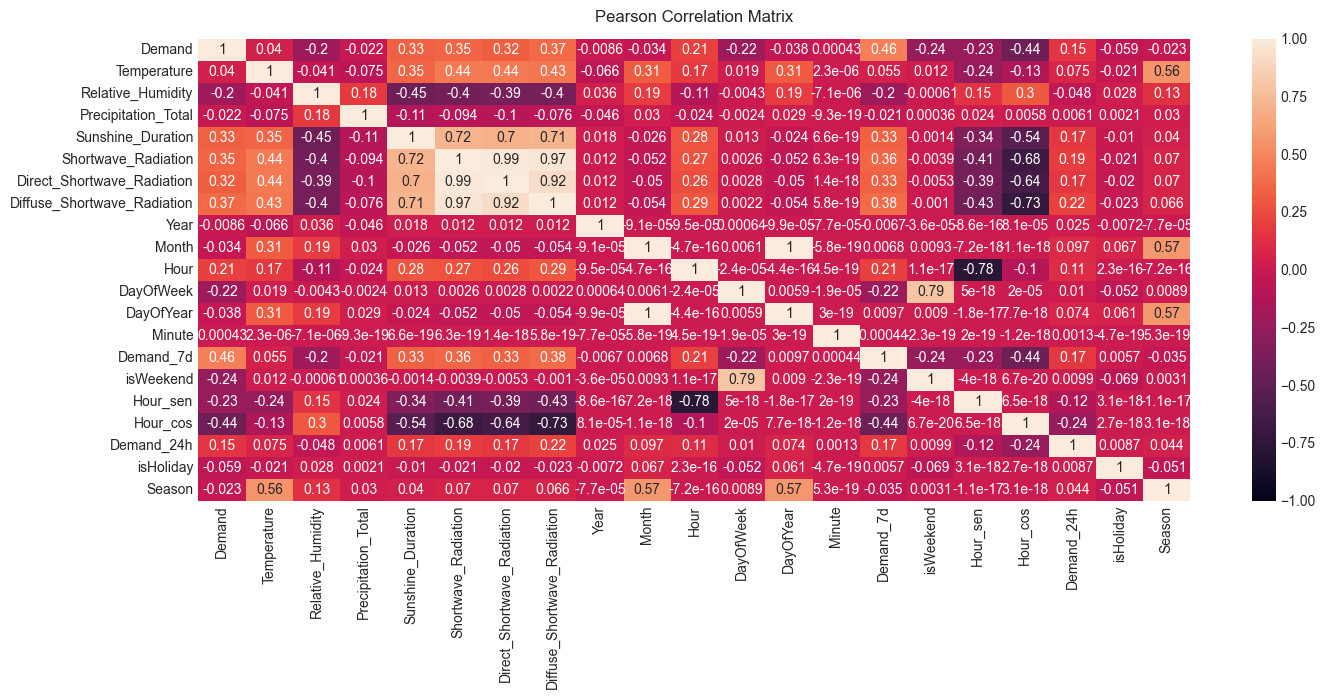

In [ ]:
#Correlation Map using Pearson Correlation
plt.figure(figsize=(16,6))
corr_df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
#Drop Columns
corr_df = corr_df.drop(columns=["Date"])
heatmap = sns.heatmap(corr_df.corr('pearson'), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Pearson Correlation Matrix', fontdict={'fontsize': 12}, pad=12)

In [ ]:
columns2drop = ["Minute", "Year"]
corr_df = corr_df.drop(columns=columns2drop)
trainingSize = int((parameters["dataset"]["trainingSize"] + parameters["dataset"]["validationSize"])* corr_df.shape[0])

X_new_train= corr_df.loc[:trainingSize, :].copy()
X_new_test = corr_df.loc[trainingSize:, :].copy()

new_model = KNeighborsRegressor(n_neighbors=100, weights='uniform')

test(X_train = X_new_train, X_test = X_new_test, model = new_model, type="All")

Nº of Days Predicted: 109 == 10512 lags, Test MAE: 22.97122526636225, RMSE: 35.57275870590092


### Battery tests

#### Set 12 KWh in Weekends

In [ ]:
df3 = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df3["Demand"][df3.isWeekend == True] = 12
df3["Demand"][df3.Hour < 8] = 12
df3["Demand"][df3.Hour > 20] = 12
dates = df3["Date"]

#Revisar columnas de pipeline
df3 = df3.drop(columns=["Date", "Minute", "Year"], axis=1)
trainingSize = int((parameters["dataset"]["trainingSize"] + parameters["dataset"]["validationSize"])* df3.shape[0])

X_train = df3.loc[:trainingSize, :].copy()
X_train_dates = dates.loc[:trainingSize].copy()
X_test = df3.loc[trainingSize:, :].copy()
X_test_dates = dates.loc[trainingSize:].copy()

model = KNeighborsRegressor(n_neighbors=33, weights='uniform')
test(X_train, X_test, model, "All")

Nº of Days Predicted: 109 == 10512 lags, Test MAE: 16.808553572252205, RMSE: 32.93509162857846
